<a href="https://colab.research.google.com/github/dkapitan/jads-nhs-proms/blob/master/notebooks/3.0-modeling-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

_taken from [narrative seminar Osteoarthritis by Hunter & Bierma-Zeinstra (2019) in the Lancet](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf)._

<TO DO: add soundbite from article, relevant for regression>

# Modeling: clustering & classfication

This is day 3 from the [5-day JADS NHS PROMs data science case study](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/outline.md).



## Learning objectives: modeling
- ...


## Learning objectives Python: Hands-on Machine Learning (2nd edition)

- [End-to-end Machine Learning project (chapter 2)](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)
- [Training linear models (chapter 3](https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb)
- [Unsupervised learning (chapter 9)](https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb)


## Recap from previous lecture
- Good outcome for knee replacement Y is measured using difference in Oxford Knee Score (OKS)
- Research has shown that an improvement in OKS score of approx. 30% is relevant ([van der Wees 2017](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/vanderwees2017patient-reported.pdf)). Hence an increase of +14 points is considered a 'good' outcome.
- to account for the ceiling effect, a high final `t1_oks_score` is also considered as a good outcome (even if `delta_oks_score` is smaller than 14).

    

In [0]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, VarianceThreshold
import sklearn.linear_model

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('ggplot')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# import data
df = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

# Data preparation in a scikit-learn Pipeline
Previously we have already discussed the various steps in data preparation using [pandas](https://pandas.pydata.org/). As explained in the [documentation of scikit-learn](https://scikit-learn.org/stable/modules/compose.html#column-transformer), this may be problematic for one of the following reasons:

* Incorporating statistics from test data into the preprocessors makes cross-validation scores unreliable (known as data leakage), for example in the case of scalers or imputing missing values.

* You may want to include the parameters of the preprocessors in a [parameter search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

To this purpose, the [`ColumnTransformer` class](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html?highlight=columntransformer#sklearn.compose.ColumnTransformer) has been recently added to scikit-learn. The documentation gives an example how to use this for [pre-processing mixed types](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py). Historically, `sklearn` transformers are designed to work with numpy arrays, not with pandas dataframes. You can use [`sklearn-pandas`](https://github.com/scikit-learn-contrib/sklearn-pandas) to bridge this gap or use `ColumnTransformer` directly on pandas DataFrames. We will use the latter.



## Using ColumnsTransformers and Pipelines

Recalling from the second lecture, we want to perform the following preprocessing per (group of) columns. In case feature requires more than one preprocessing step, the use of `Pipeline` is recommended.

### Passing 1D or 2D arrays in your `Pipeline`
It is important to remember that `scikit-learn` can be quite fussy about the difference between passing 1D arrays/series and 2D arrays/dataframes.

For example, the following code will result in an error because `categories` needs to be a list of lists:
```
enc = OrdinalEncoder(categories=age_band_categories)
enc.fit(df[age_band])
```

The correct code is (brackets!):
```
enc = OrdinalEncoder(categories=[age_band_categories])
enc.fit(df[age_band])
```


### Beware: difference between `OrdinalEncoder` and `OneHotEncoding`
Using `OrdinalEncoder` to generate an integer representation of a categorical variable can not be used directly with all scikit-learn estimators, as these expect continuous input, and would interpret the categories as being ordered, which is often not desired.

Another possibility to convert categorical features to features that can be used with scikit-learn estimators is to use a one-of-K, also known as one-hot or dummy encoding. This type of encoding can be obtained with the OneHotEncoder, which transforms each categorical feature with n_categories possible values into n_categories binary features, with one of them 1, and all others 0.

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# group columns
age_band = ['age_band']
gender = ['gender']
age_band_categories = sorted([x for x in df.age_band.unique() if x])
comorb = ['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease',
          'diabetes', 'kidney_disease', 'nervous_system', 'liver_disease',
          'cancer', 'depression', 'arthritis']
boolean = ['t0_assisted', 't0_previous_surgery', 't0_disability']
eq5d = ['t0_mobility', 't0_self_care', 't0_activity', 't0_discomfort',
        't0_anxiety']
eq_vas = ['t0_eq_vas']
categorical = ['t0_symptom_period', 't0_previous_surgery',
               't0_living_arrangements']
oks_questions = [col for col in df.columns 
                 if col.startswith('oks_t0')
                 and not col.endswith('_score')]
oks_score = ['oks_t0_score']

# preprocessing pipelines for specific columns
age_band_pipe = Pipeline(
    steps=[('impute',
            SimpleImputer(missing_values=None,
            strategy='most_frequent')),
           ('ordinal',
            OrdinalEncoder(categories=[age_band_categories])),
           ])

gender_pipe = Pipeline(
    steps=[('impute',
           SimpleImputer(missing_values=np.nan,
                         strategy='most_frequent')),
           ('onehot', OneHotEncoder()),
           ])


# ColumnTransformer on all included columns.
# Note columns that are not specified are dropped by default
transformers = {
    'age': ('age', age_band_pipe, ['age_band']),
    'gender': ('gender', gender_pipe, gender),
    'comorb': ('comorb',
               SimpleImputer(missing_values=9,
                             strategy='constant',
                             fill_value=0),
               comorb),
    'categorical': ('categorical',
                    SimpleImputer(missing_values=9,
                                 strategy='most_frequent'),
                    boolean + eq5d + categorical),
    'oks': ('oks',
            SimpleImputer(missing_values=9,
                          strategy='most_frequent'),
            oks_questions),
    'oks_score': ('oks_score',
                   SimpleImputer(missing_values=np.nan,
                                 strategy='most_frequent'),
                   oks_score),
    'eq_vas': ('eqvas',
               SimpleImputer(missing_values=999,
                             strategy='median'),
               eq_vas),         
}
prep = ColumnTransformer(
    transformers=[v for _, v in transformers.items()])

prep.fit(df)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('age',
                                 Pipeline(memory=None,
                                          steps=[('impute',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=None,
                                                                strategy='most_frequent',
                                                                verbose=0)),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['40 '
                                                                              'to '
        

## Writing custom transformers (advanced, see Géron chapter 2)
Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods: fit() (returning self), transform(), and fit_transform().

When writing transformers for data preparation, you only need to define `transform()`. Basically, `ColumnTransformer` passes only the subset of columns from the original dataframe to the transformer. So when writing your own transformer you don't need to do any subsetting, but you can assume that the `transform()` method should be applied to the whole dataframe.



In [0]:
# just as an example, not used in Pipeline
class ReplaceSentinels(BaseEstimator, TransformerMixin):
    """Replace sentinel values in dataframe.
    
    Attributes:
        sentinel: sentinel value, default 9
        replace_with: value to replace sentinel with, default np.nan
    """
    def __init__(self, sentinel = 9, replace_with=np.nan):
        self.sentinel = sentinel
        self.replace_with = replace_with
    def fit(self, X, y=None):
        return self
    def transform(self, X, ):
        return X.replace(9, self.replace_with)


# Training linear models

## Simple regression
Regression of `t1_eq_vas` ~ `t0_eq_vas`

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


def fill_median(s):
    return s.fillna(value=s.median()).to_frame() 

eq = ['t0_eq_vas', 't1_eq_vas']
eq_prep = ColumnTransformer(transformers=
                            [('eq',
                              SimpleImputer(missing_values=999,
                                            strategy='median'),
                              eq),
                            ])
eq_prep.fit(df)
t0_eq, t1_eq = eq_prep.transform(df)[:,0], eq_prep.transform(df)[:,1] 
eq_reg = LinearRegression()
eq_reg.fit(t0_eq.reshape(-1,1), t1_eq)
eq_reg.intercept_, eq_reg.coef_, eq_reg.score(t0_eq.reshape(-1,1), t1_eq)

(54.05177947350987, array([0.31047358]), 0.11639490255274676)

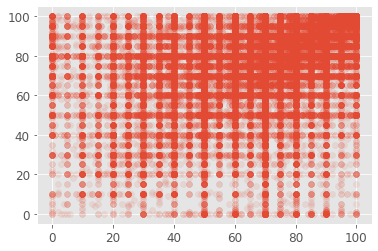

In [30]:
plt.scatter(t0_eq, t1_eq, alpha=0.1);

## Regression t0_eq_vas with OKS

In [34]:
oks_lm = Pipeline(steps=
                   [('prep', ColumnTransformer(transformers=[transformers['oks']])),
                    ('lm', LinearRegression())])
X_train, X_test, y_train, y_test = train_test_split(df[oks_questions], t0_eq, test_size=0.2)
X_test = SimpleImputer(missing_values=9, strategy='most_frequent').fit_transform(X_test)
oks_lm.fit(X_train, y_train)

# you can read attritbutes from named_steps
oks_lm.named_steps.lm.intercept_, oks_lm.named_steps.lm.coef_ , oks_lm.named_steps.lm.score(X_test, y_test)

# TO DO: how to use data-prep on X_test and y_test in a nice way?

(48.21890807793366,
 array([-0.21036476,  0.29457275,  2.65071634,  0.75997118,  0.82601278,
        -0.28385024, -0.31317094,  0.62928433,  1.72759244,  0.54085395,
         2.05605176,  0.74748747]),
 0.1290590611413044)

# Conclusion and reflection

## Discussion of results

* ...
* ...

## Checklist for results from data preparation process
* ...
* ...